In [34]:
import os

import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import requests
import scipy.sparse as sps
import sklearn.neighbors as nbrs
import torch
import torch.optim as optim
import torch.nn as nn
import torch.sparse as tsps
import torch_sparse
import torch_scatter as tsct
import torch_geometric.nn as gnn
import torch_geometric

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise.accuracy import mae

if True:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Recommender Systems Using Geometric Deep Learning
## Recursive Graph Convolutional Neural Networks

A novel paradigm, [geometric deep learning](http://geometricdeeplearning.com/), has recently emerged in the deep learning community.

This will walk through the algorithm outlined in "Geometric Matrix Completion with Recurrent Multi-Graph Neural Networks", by Monti, Bronstein, and Bresson.

As we're probably familiar with already, standard Linear Neural Networks have an exponential explosion of parameters for high dimensional data.  It becomes infeasible to train even relatively shallow networks on a large input vector, not just for training time but for training samples as well.

Linear:
$$
y = \xi (\sum_{l=1}^d w_l x_l + b)
$$

Recurrent Neural Networks solve this problem by remembering a history, allowing the network's number of parameters to be constant along the time or sequence dimension. Of course, this is most effective for sequenced data, with one "sequential" dimension.

Convolutional Neural Networks solve this problem by sharing weights, allowing a static number of parameters across the image dimensions. Of course, this admits a specific data structure: images and things which are image-like. Locality of connections are understood in euclidean space.

Convolutional:
$$
y_{c} = \xi (\sum_{l=1}^d ( w_{lc} \ast x_l))
$$

Geometric Deep Learning, by contrast, takes in the concept of a convolutional neural network, and abstracts the convolution operator to work with a graph structure.

For example, this example will utilize spectral convolutions, defned by:

$$
y_{c} = \xi (\sum_{l=1}^{d} \Phi W_{lc} \Phi^T x_l) = \xi (\sum_{l=1}^d ( W_{lc} \circledast x_l))
$$

Where $\Phi$ is called a *spectral transfer function*, analogous to the Fourier transform for sequential signals.

For this paper, they use Chebychev Polynomials to smooth this operator, as normally it is quite unstable.

smooth spectral transfer $\tau$:
$$\begin{aligned}
\tau(\Delta) f = \Phi \tau(\Lambda) \Phi^T f
\end{aligned}$$

Chebychev polynomial:
$$\begin{aligned}
\tau_\alpha (\Delta) = \sum_{l=0}^d \alpha_d L
\end{aligned}$$

where $\alpha_d$ are the filter parameters for a filter $\alpha$, d is the number of input channels (or size of the input vector), and L is the graph laplacian.

Then a feature map can be calculated:

$$
y_n = \xi(\sum_{l=0}^d g_{\alpha_d} L x_{n,d})
$$

The above figure along with the outline of backpropogation of this layer can be found in "Convolutional Neural Networks on Graphs with Fast Spectral Filtering" by Defferrard, Bresson, and Vanderghynst.



### Recommender Systems

Recommender systems are a common problem in business applications such as Amazon or Netflix, where we have a set of items, a set of users, and a set of user-ratings on items to connect them.  This generall takes the shape of a very sparse, massive, matrix.

Using traditional deep learning methods can be computationally infeasible, and even after dimensionality reduction, it is difficult to frame a traditional deep learning method with training examples. It can require a lot of feature engineering just to create a trainable model.

A common practice is to use singular value decomposition to simplify the problem:

$$
X = U \Sigma V
$$

Then, a loss function is used to have this model predict some stashed away user/item ratings, essentially smoothing the matrix until it fills in predictions for any given value.

Here, we will take this approach and allow a deep learning model to try and learn some hidden data using only X.

We start by splitting the data into 3 parts, a training, validation, and test set.  The validation set sort of takes the place of "training labels", and will be used for evaluation of the loss function.


#### The Data

We'll take the Movielens 100k dataset, as it is an easy open-source dataset to use as a toy example, and won't take very long to train on. It consists of some ~100k ratings of ~1000 users and ~1000 movies.


In [2]:
items = ['u.item', 'ua.base', 'ua.test']
print('downloading files...')
for item in items:
    if os.path.exists(item):
        continue
    url = 'http://files.grouplens.org/datasets/movielens/ml-100k/%s' % item
    r = requests.get(url, stream=True)
    with open(item, 'w') as fd:
        for content in r.iter_content():
            fd.write(str(content, encoding='latin1'))
item_features = pd.read_csv('u.item', sep='|', header=None, names=[
    'movie id', 'movie title', 'release date', 'video release date',
    'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
    'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 
    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
    'Sci-Fi', 'Thriller', 'War', 'Western'])
item_features.drop(columns=['video release date', 'IMDb URL'], inplace=True)
print('done!')

downloading files...
done!


In [3]:
item_features.head()

,movie id,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [4]:
features = item_features[['unknown', 'Action', 'Adventure', 'Animation',
    'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 
    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
    'Sci-Fi', 'Thriller', 'War', 'Western']]
# algo = nbrs.NearestNeighbors(n_neighbors=11).fit(features)
WA = nbrs.kneighbors_graph(features, n_neighbors=10)
np.argwhere(WA[0:5].toarray() > 0)[:50:5]

array([[  0,  94],
       [  0, 239],
       [  1, 116],
       [  1, 981],
       [  2, 197],
       [  2, 614],
       [  3,  73],
       [  3, 597],
       [  4,  10],
       [  4, 347]])

In [5]:
train_df = pd.read_csv('ua.base', sep="\t", names=['uid', 'iid', 'rating', 'time'])
test_df = pd.read_csv('ua.test', sep='\t', names=['uid', 'iid', 'rating', 'time'])

In [6]:
fields = ['uid', 'iid', 'rating']
reader = Reader(rating_scale=(1, 5))
train_set = Dataset.load_from_df(df=train_df[fields], reader=reader)
full = train_set.build_full_trainset()
i, j, data = zip(*full.all_ratings())
i = list(i)
j = list(j)
full = sps.coo_matrix((data, (i, j)))
test = Dataset.load_from_df(df=test_df[fields], reader=reader).build_full_trainset()
train, validate = train_test_split(train_set, test_size=0.2)

In [7]:
i, j, data = zip(*train.all_ratings())
i = list(i)
j = list(j)
X = sps.coo_matrix((data, (i, j)))

In [8]:
i, j, data = zip(*validate)
i = [int(ia) for ia in i]
j = [int(ja) for ja in j]
Y = sps.coo_matrix((data, (i, j)))
X.resize(Y.shape)

In [9]:
HA = nbrs.kneighbors_graph(X, n_neighbors=10)
np.argwhere(HA[0:5].toarray() > 0)[:40:5]

array([[  0, 156],
       [  0, 831],
       [  1,  69],
       [  1, 717],
       [  2, 245],
       [  2, 650],
       [  3, 420],
       [  3, 821]])

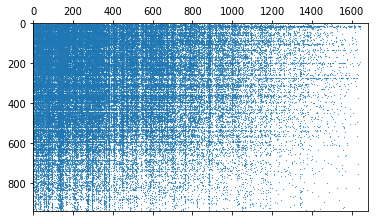

In [10]:
plt.spy(X, precision='present', markersize=0.2)

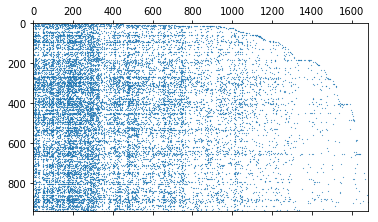

In [11]:
plt.spy(Y, precision='present', markersize=0.2)

In [12]:
# density
len(X.data) / np.product(X.shape)

0.045632721336584775

In [13]:
U, Sigma, V = sps.linalg.svds(X, k=10)
H = U * Sigma
W = V.T * Sigma

HA = sps.coo_matrix(HA)
WA = sps.coo_matrix(WA)

Xorig = X.copy()
Xorig.resize(Y.shape)

In [14]:
test = Dataset.load_from_df(df=test_df[fields], reader=reader).build_full_trainset()
i, j, data = zip(*test.all_ratings())
Test = sps.coo_matrix((data, (i, j)))
Test.resize(X.shape)

#### The Model

we have now decomposed the matrix X, into two components H, and W, which represent the users and items (movies) respectively. The trick here, is to now imagine this as two graphs: one in which we relate users, and one in which we relate items. We will allow a deep learning model to traverse these graph features for each H and W, and update them.

**Figure of separable Recurrent RGCNN**

The features of each graph, H, and W, are the remaining components from the svd dimensionality reduction. The nodes are the users, and items respectively.  The GCNN convolves over the matrix-graph, and outputs a graph $H'$ with some number of channels/features and the same number of users (nodes).  This is then fed into the LSTM layer on a per-user basis.  For each user, the LSTM outputs a shift $dH$ which adjusts the scores for that user's components. Rinse and repeat for W.

The trick here, is that we limit the number of times this iterative process occurs to some $T$.  We'll call this the diffusion time.  By passing $dH$ through a tanh nonlinearity, we allow ratings to "diffuse" around slightly, limiting the maximum diffusion.  After $T$ iterations, and this constitutes a *single* forward pass, and loss is then backpropogated to the parameters.


In [15]:
def combine(H, W, minimum=1, maximum=5):
    Xpred = torch.mm(H, torch.transpose(W, 0, 1))
    Xpred = minimum + (maximum - 1) * (Xpred - torch.min(Xpred)) / (torch.max(Xpred) - torch.min(Xpred))
    return Xpred


# for computation of loss
def frobenius_norm(x):
    """norm for matrices"""
    x2 = x ** 2
    x2sum = torch.sum(x2)
    return torch.sqrt(x2sum)


def graph_norm(X, laplacian):
    norm = torch.mm(torch.transpose(X, 0, 1), tsps.mm(laplacian, X))
    return norm


def recommender_loss(inputs, laplacians, target, mask, extrema, gamma=1e-10):
    # loss function borrowed from objective in Srebro et. al 2004.
    H, W = inputs
    Lh, Lw = laplacians

    # set X to valid ratings
    X = torch.mm(H, torch.transpose(W, 0, 1))
    X_normed = extrema[0] + (extrema[1] - 1) * (X - torch.min(X)) / (torch.max(X) - torch.min(X))

    # consider only original data and test data, ignore other sparse values.
    xm = mask.to_dense() * (X_normed - target)
    fnorm = frobenius_norm(xm)
    fnorm = fnorm / torch.sum(mask.to_dense())

    # compute regularization
    gH = graph_norm(H, Lh)
    gW = graph_norm(W, Lw)
    loss = fnorm + (gamma / 2) * (torch.trace(gH) + torch.trace(gW))
    return loss

def tensor_from_scipy_sparse(X):
    values = X.data
    indices = np.vstack((X.row, X.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    X = torch.sparse.FloatTensor(i, v, torch.Size(X.shape))
    return X


In [31]:
class RGCNNFactorization(nn.Module):

    def __init__(self, input_shape, factorization_rank=10, n_channels=32,
                 basis_order=5, diffusion_time=10, hidden_cells=32,
                 lstm_layers=1, bidirectional=False):
        super().__init__()

        # GCNN parameters
        self.m = input_shape[0]
        self.n = input_shape[1]
        self.r = factorization_rank
        self.q = n_channels
        self.order = basis_order

        # LSTM parameters
        self.nH = hidden_cells
        self.T = diffusion_time
        self.n_layers = lstm_layers
        self.bidirectional = False

        # GCNNs for H, W matrices
        self.hconv = gnn.ChebConv(in_channels=self.r, out_channels=self.q,
                                  K=self.order)
        self.wconv = gnn.ChebConv(in_channels=self.r, out_channels=self.q,
                                  K=self.order)

        # RNN
        self.lstm = nn.LSTM(input_size=self.q, hidden_size=self.nH,
                            num_layers=self.n_layers, bidirectional=self.bidirectional,
                            batch_first=True)

        self.dense_H = nn.Linear(in_features=self.nH, out_features=self.r)

        self.dense_W = nn.Linear(in_features=self.nH, out_features=self.r)

        self.loss_fn = recommender_loss

    def init_hidden(self):
        h0 = torch.zeros((self.q,)).view(1, 1, -1)
        c0 = torch.zeros((self.q,)).view(1, 1, -1)
        return h0, c0

    def forward(self, H, W, HA, WA):
        hidden = self.init_hidden()
        for i in range(self.T):
            conv1 = self.hconv(H, HA)
            Htilde = torch.sigmoid(conv1)
            out, hidden = self.lstm(Htilde.unsqueeze(0), hidden)
            dout = self.dense_H(out)
            dH = torch.tanh(dout).squeeze()
            Hout = H + dH

            conv2 = self.wconv(W, WA)
            Wtilde = torch.sigmoid(conv2)
            out, hidden = self.lstm(Wtilde.unsqueeze(0), hidden)
            dout = self.dense_W(out)
            dW = torch.tanh(dout).squeeze()
            Wout = W + dW

        return Hout, Wout

    def train(self, H, W, HA, WA, Y,  Xorig, Test, iters, optimizer=None):
        if optimizer is None:
            optimizer = optim.Adam(self.parameters(), lr=1e-4)

        loss_history = np.zeros((iters,))
        error_history = np.zeros((iters,))

        testmask = sps.coo_matrix((np.ones_like(Test.data), (Test.row, Test.col)))
        testmask.resize(Xorig.shape)
        testmask = tensor_from_scipy_sparse(testmask).cuda()
        Test = tensor_from_scipy_sparse(Test).cuda()

        maximum = np.max(Y)
        minimum = np.min(Y)
        M = sps.coo_matrix(Y + Xorig)
        allmask = tensor_from_scipy_sparse(sps.coo_matrix((np.ones_like(M.data), (M.row, M.col)))).cuda()
        # Y = tensor_from_scipy_sparse(Y).cuda()
        M = tensor_from_scipy_sparse(M).cuda()

        Lh = sps.csgraph.laplacian(HA)
        Lw = sps.csgraph.laplacian(WA)
        Lh = tensor_from_scipy_sparse(Lh).cuda()
        Lw = tensor_from_scipy_sparse(Lw).cuda()

        H = torch.tensor(H).float().cuda()
        W = torch.tensor(W).float().cuda()
        HA = torch.tensor([HA.row, HA.col]).long().cuda()
        WA = torch.tensor([WA.row, WA.col]).long().cuda()

        for i in range(iters):

            Hout, Wout = self.forward(H, W, HA, WA)
            loss = self.loss_fn((Hout, Wout), (Lh, Lw), M, allmask, (minimum, maximum))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_history[i] = loss.item()
            Xpred = combine(Hout, Wout)
            error_history[i] = self.predict(Xpred, Test, testmask)
            print('iter %s: loss: %s, error: %s' % (i, loss_history[i], error_history[i]))

        return Hout.cpu().detach(), Wout.cpu().detach(), loss_history, error_history

    def predict(self, X, Y, Mask=None, norm=False):
        if norm:
            X = 1 + 4 * (X - torch.min(X)) / (torch.max(X) - torch.min(X))
        if Mask is None:
            Mask = sps.coo_matrix((np.ones_like(Y.data), (Y.row, Y.col)), shape=Y.shape)
            Mask = tensor_from_scipy_sparse(Mask)
            Y = tensor_from_scipy_sparse(Y)
        predictions = X * Mask.to_dense()
        predictions_error = torch.sum(torch.abs(predictions - Y)) / torch.sum(Mask.to_dense())
        return predictions_error.item()

In [18]:
from glob import glob
model = RGCNNFactorization(X.shape)
# model.train(H, W, HA, WA, Y, Xorig, Test, 100)
model = RGCNNFactorization(X.shape).load_state_dict(torch.load(glob('models/model5000_*.pickle')[-1]))

In [38]:
algo = SVDpp(n_factors=10)
algo.fit(train_set.build_full_trainset())


In [39]:
mae(algo.test(test.build_testset()))

MAE:  0.7404


0.7403789937390115